In [ ]:
import os
os.chdir('/het/p4/ramirez/gcewavelets/skysearch/code/')

In [42]:
import numpy as np
import sys, os
import _maps as maps

In [43]:
import healpy as hp
import astropy_healpix

In [44]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [45]:
# load local directory
username="ramirez"
local_dir = "/het/p4/"+username+"/gcewavelets/skysearch/"
maps_dir = "/het/p4/"+username+"/gcewavelets/skysearch/data/maps/"

# ---
 # Block: Specify map ids
model = 'ilias_60x60' # only available option: SA0
trial_id = str(0)
model_dir = maps_dir + (model + '_' + trial_id + '/')
energy_bin = '16'
map_type = 'all'

# load events from map 
if energy_bin == 'all' or energy_bin == str(-1):
    if map_type == 'bkgd':
        map_dir = model_dir + 'bkgd/'
    elif map_type == 'all':
        inj_id = str(0)
        map_dir = model_dir + ('bkgd_wps_' + inj_id + '/') 
else:
    ie = int(float(energy_bin))
    if map_type == 'bkgd':
        bkgd_dir = model_dir + 'bkgd/'
        map_dir = bkgd_dir + 'energy_bin_' + str(ie) + '/'
    elif map_type == 'all':
        inj_id = str(0)
        bkgd_wps_dir = model_dir + ('bkgd_wps_' + inj_id + '/')
        map_dir = bkgd_wps_dir + 'energy_bin_' + str(ie) + '/'  

data_dir = map_dir + 'projected_maps/'
# ---

# load father pixel and data
npix = np.random.randint(192)
npix = 112
patch_dir = data_dir + 'map_' + str(npix) + '/'

In [46]:
a_deg = 0.3
str_a_deg = str.format('{0:.5f}',a_deg)

wavelet_name = 'mexh'
grid_scale_deg = 0.1
str_grid_scale_deg = str.format('{0:.4f}',grid_scale_deg)
file_name = wavelet_name + '_' + 'coefficient_map' + '_' + str_a_deg + '_' + str_grid_scale_deg + '.npy'
cwt_map = np.load(patch_dir + file_name, allow_pickle = True)
projected_map = dict(np.load(patch_dir + 'projected_map_dict.npz'))

# decided to separate grid and projected maps into two different dictionaries
# grid is defined using the total background map for all energies
grid_dict = dict(np.load(patch_dir + 'grid_dict_' + str_grid_scale_deg + '_' + '.npz'))
mesh_bxby = grid_dict['rectangular_grid']
grid = grid_dict['grid']

In [47]:
data = projected_map['outmost_region_points']
mesh_bxby = grid_dict['rectangular_grid']
grid = grid_dict['grid']

In [48]:
r_out_edge = projected_map['outer_region_edge']
x_out_edge = r_out_edge[:,0] ; y_out_edge = r_out_edge[:,1]
bx_min, bx_max, by_min, by_max = [np.min(x_out_edge), np.max(x_out_edge),
                                  np.min(y_out_edge), np.max(y_out_edge)]

In [49]:
scale = 0.1 * np.pi / 180
step_size = scale 
mesh_bxby, arr_b, arr_bx_plot, arr_by_plot = maps.build_mesh_(bx_min, bx_max, by_min, by_max, step_size, step_size, return_arrays_for_plotting=True)

(-0.22575039922668377,
 0.2262898770398482,
 -0.20317234408792986,
 0.2034893716267495)

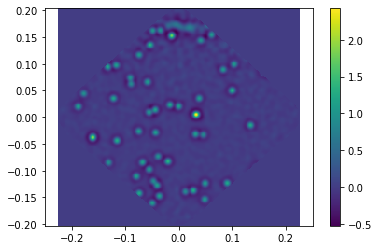

In [50]:
fig = plt.figure(1,figsize=(6,4))
ax = fig.add_subplot(111)

plot = plt.pcolormesh(arr_bx_plot, arr_by_plot, cwt_map[:,:,0], cmap='cividis', shading='flat'
                     , norm=mpl.colors.Normalize(vmin=np.min(cwt_map[:,:,0]), 
                                                 vmax=np.max(cwt_map[:,:,0])))
plt.pcolormesh(arr_bx_plot, arr_by_plot, cwt_map[:,:,0])
plt.colorbar()
ax.axis('equal')

(-0.22575039922668377,
 0.2262898770398482,
 -0.20317234408792986,
 0.2034893716267495)

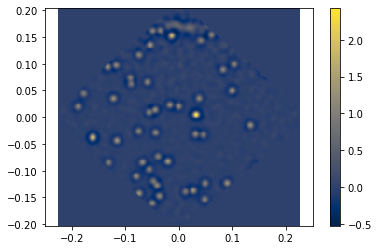

In [51]:
fig = plt.figure(1,figsize=(6,4))
ax = fig.add_subplot(111)

plot = plt.pcolormesh(arr_bx_plot, arr_by_plot, cwt_map[:,:,0], cmap='cividis', shading='flat'
                     , norm=mpl.colors.Normalize(vmin=np.min(cwt_map[:,:,0]), 
                                                 vmax=np.max(cwt_map[:,:,0])))
plt.colorbar(plot)
ax.axis('equal')

(-0.22575039922668377,
 0.2262898770398482,
 -0.20317234408792986,
 0.2034893716267495)

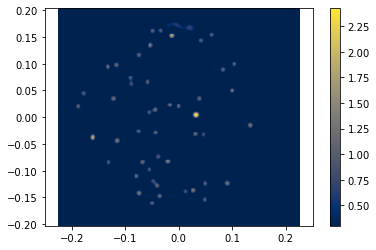

In [52]:
fig = plt.figure(1,figsize=(6,4))
ax = fig.add_subplot(111)

plot = plt.pcolormesh(arr_bx_plot, arr_by_plot, cwt_map[:,:,0], cmap='cividis', shading='flat'
                     , norm=mpl.colors.Normalize(vmin=0.3, 
                                                 vmax=np.max(cwt_map[:,:,0])))
plt.colorbar(plot)
ax.axis('equal')

In [53]:
S0 = 0.3
cwt_map_thresh = np.copy(cwt_map[:,:,0])
thresh_map = (cwt_map_thresh > S0)
cwt_map_thresh[~thresh_map] = 0

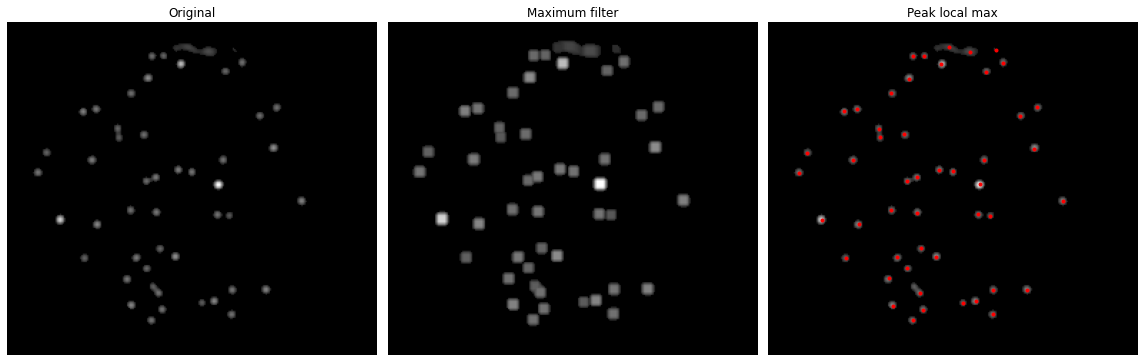

In [54]:
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage import data, img_as_float

# single a-value 
psf_degree = 0.16 
psf_scale = psf_degree * np.pi / 180
grid_scale = 0.1 * np.pi / 180
N_pix_psf = int(3*psf_scale / grid_scale)

# image_max is the dilation of im with a 20*20 structuring element
# It is used within peak_local_max function
image_max = ndi.maximum_filter(cwt_map_thresh, size=N_pix_psf, mode='constant')

# Comparison between image_max and im to find the coordinates of local maxima
coordinates = peak_local_max(cwt_map_thresh, min_distance=N_pix_psf, 
                             threshold_abs = S0)

# display results
fig, axes = plt.subplots(1, 3, figsize=(8*2, 6))
ax = axes.ravel()
ax[0].imshow(cwt_map_thresh, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Original')
ax[0].invert_yaxis()

ax[1].imshow(image_max, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('Maximum filter')
ax[1].invert_yaxis()

ax[2].imshow(cwt_map_thresh, cmap=plt.cm.gray)
ax[2].autoscale(False)
ax[2].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
# ax[2].plot(ps_approx[1], ps_approx[0], 'b.')
ax[2].axis('off')
ax[2].set_title('Peak local max')
ax[2].invert_yaxis()

fig.tight_layout()

plt.show()

In [55]:
arr_bx = 0.5 * (arr_bx_plot[:-1] + arr_bx_plot[1:])
arr_by = 0.5 * (arr_by_plot[:-1] + arr_by_plot[1:])

(-0.22575039922668377,
 0.2262898770398482,
 -0.20317234408792986,
 0.2034893716267495)

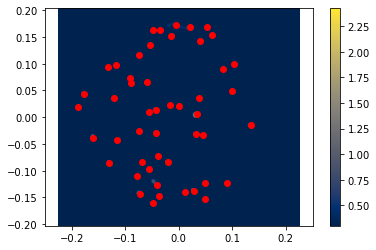

In [56]:
fig = plt.figure(1,figsize=(6,4))
ax = fig.add_subplot(111)

nx = coordinates[:,1]
ny = coordinates[:,0]

pos_x = arr_bx[nx]
pos_y = arr_by[ny]

plot = plt.pcolormesh(arr_bx_plot, arr_by_plot, cwt_map[:,:,0], cmap='cividis', shading='flat'
                     , norm=mpl.colors.Normalize(vmin=0.3, 
                                                 vmax=np.max(cwt_map[:,:,0])))
plt.scatter(pos_x, pos_y, c = 'r')
plt.colorbar(plot)
ax.axis('equal')

In [57]:
arr_edge_points = projected_map['search_region_edge']
x_edge = arr_edge_points[:,0] ; y_edge = arr_edge_points[:,1]
x_in, y_in = maps.find_points_inside_curve_(pos_x, pos_y, x_edge, y_edge)

(-0.22575039922668377,
 0.2262898770398482,
 -0.20317234408792986,
 0.2034893716267495)

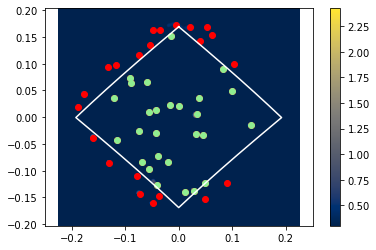

In [58]:
fig = plt.figure(1,figsize=(6,4))
ax = fig.add_subplot(111)

nx = coordinates[:,1]
ny = coordinates[:,0]

pos_x = arr_bx[nx]
pos_y = arr_by[ny]

plot = plt.pcolormesh(arr_bx_plot, arr_by_plot, cwt_map[:,:,0], cmap='cividis', shading='flat'
                     , norm=mpl.colors.Normalize(vmin=0.3, 
                                                 vmax=np.max(cwt_map[:,:,0])))
plt.plot(x_edge, y_edge, c = 'white')
plt.scatter(pos_x, pos_y, c = 'r')
plt.scatter(x_in, y_in, c = 'lightgreen')
plt.colorbar(plot)
ax.axis('equal')

In [59]:
lon_c, lat_c = projected_map['center_coords']

In [60]:
r_ps = np.array([maps.inv_tangent_plane_proj_(x_in[n], y_in[n], lon_c, lat_c) for n in range(len(x_in))])

In [61]:
from astropy_healpix import HEALPix
NSIDE = 4
ahp = HEALPix(nside = NSIDE, order = 'ring')
lon_edge, lat_edge = ahp.boundaries_lonlat([npix], step = 100)

In [62]:
lon_edge = np.array(lon_edge[0,:]) ; lat_edge = np.array(lat_edge[0,:])

In [63]:
lon_edge.shape

(400,)

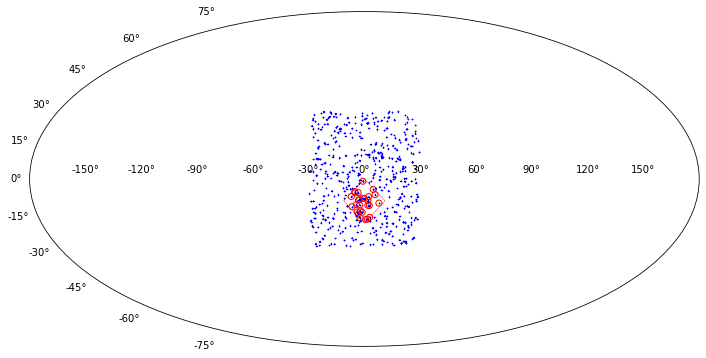

In [70]:
fig = plt.figure(1,figsize=(12,8))
ax = fig.add_subplot(111, projection='mollweide')

plt.scatter(r_ps[:,0] - np.pi, r_ps[:,1], facecolors = 'none', edgecolors = 'r')
plt.plot(lon_edge - np.pi, lat_edge, lw = 0.4, c = 'red')
plt.scatter(lon_events_ps - np.pi, lat_events_ps, s = 0.001, c = 'blue')

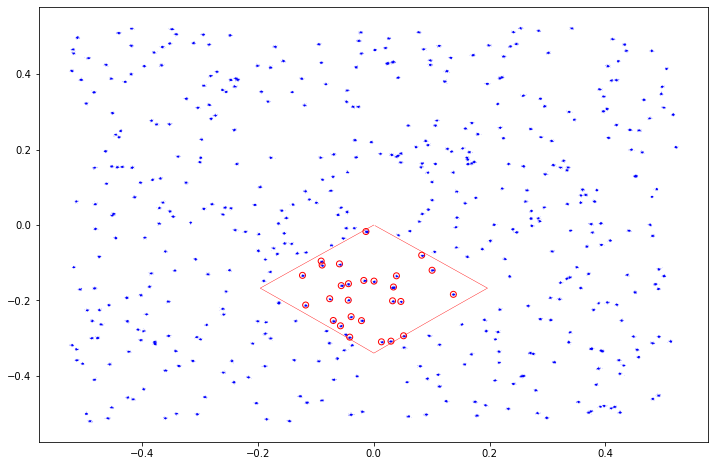

In [71]:
fig = plt.figure(1,figsize=(12,8))
ax = fig.add_subplot(111)

plt.scatter(r_ps[:,0] - np.pi, r_ps[:,1], facecolors = 'none', edgecolors = 'r')
plt.plot(lon_edge - np.pi, lat_edge, lw = 0.4, c = 'red')
plt.scatter(lon_events_ps - np.pi, lat_events_ps, s = 0.001, c = 'blue')

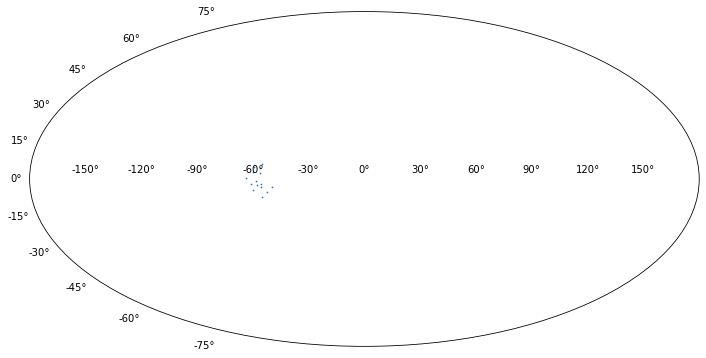

In [31]:
r_ps_all = np.load('ps_candidates.npy', allow_pickle = True)

fig = plt.figure(1,figsize=(12,8))
ax = fig.add_subplot(111, projection='mollweide')

for n in range(93,94):
    r_ps = r_ps_all[n]
#     ax.scatter(r_ps[:,0] - np.pi, r_ps[:,1], facecolors = 'none', edgecolors = 'r')
    ax.scatter(r_ps[:,0] - np.pi, r_ps[:,1], s = 0.5)

In [32]:
np.sum([r_ps_all[n].shape[0] for n in range(192)])

2627

In [33]:
events = np.load(map_dir + 'map.npy', allow_pickle = True)
l_events = events[:,0]
b_events = events[:,1]

phi_events = l_events.copy()
phi_events[phi_events>np.pi] = phi_events[phi_events>np.pi]-2*np.pi

lon_events = phi_events + np.pi
lat_events = b_events

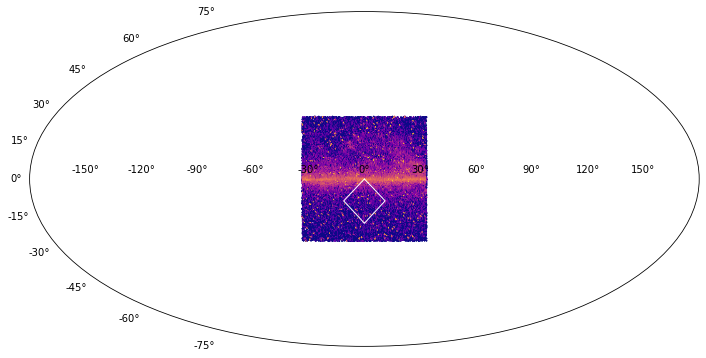

In [34]:
fig = plt.figure(1,figsize=(12,8))
ax = fig.add_subplot(111, projection='mollweide')

ax.hexbin(lon_events - np.pi, lat_events, gridsize=200,cmap='plasma',mincnt=1, bins = 'log')
plt.plot(lon_edge - np.pi, lat_edge, lw = 1, c = 'white')

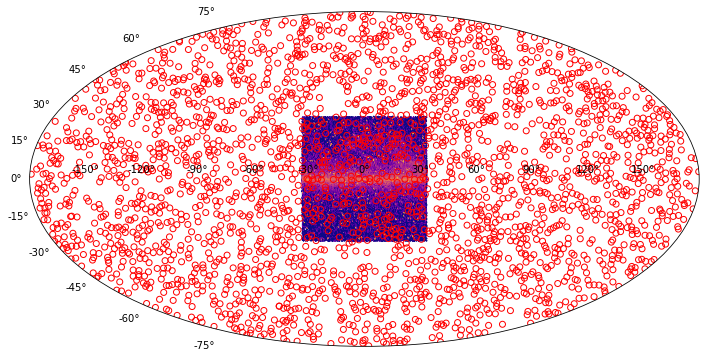

In [35]:
fig = plt.figure(1,figsize=(12,8))
ax = fig.add_subplot(111, projection='mollweide')

ax.hexbin(lon_events - np.pi, lat_events, gridsize=200,cmap='plasma',mincnt=1, bins = 'log')
for n in range(192):
    r_ps = r_ps_all[n]
    ax.scatter(r_ps[:,0] - np.pi, r_ps[:,1], facecolors = 'none', edgecolors = 'r')

In [36]:
events_ps = np.load(map_dir + 'ps_map.npy', allow_pickle = True)
l_events_ps = events_ps[:,0]
b_events_ps = events_ps[:,1]

phi_events_ps = l_events_ps.copy()
phi_events_ps[phi_events_ps>np.pi] = phi_events_ps[phi_events_ps>np.pi]-2*np.pi

lon_events_ps = phi_events_ps + np.pi
lat_events_ps = b_events_ps

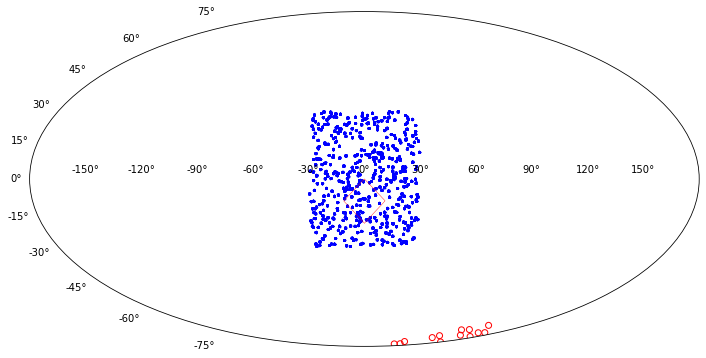

In [37]:
fig = plt.figure(1,figsize=(12,8))
ax = fig.add_subplot(111, projection='mollweide')

plt.scatter(r_ps[:,0] - np.pi, r_ps[:,1], facecolors = 'none', edgecolors = 'r')
plt.plot(lon_edge - np.pi, lat_edge, lw = 0.4, c = 'red')
plt.scatter(lon_events_ps - np.pi, lat_events_ps, s = 0.5, c = 'blue')

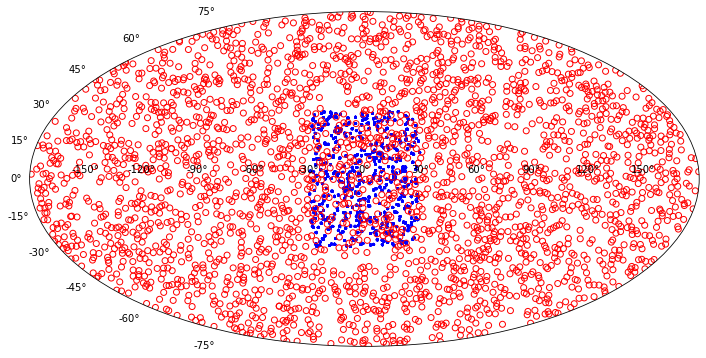

In [38]:
fig = plt.figure(1,figsize=(12,8))
ax = fig.add_subplot(111, projection='mollweide')

ax.scatter(lon_events_ps - np.pi, lat_events_ps, s = 0.5, c = 'blue')
for n in range(192):
    r_ps = r_ps_all[n]
    ax.scatter(r_ps[:,0] - np.pi, r_ps[:,1], facecolors = 'none', edgecolors = 'r')

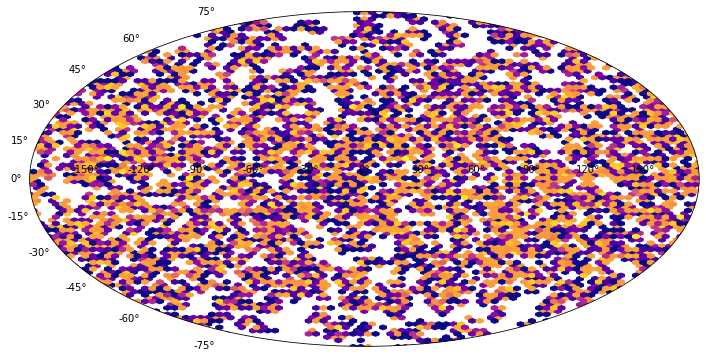

In [173]:
fig = plt.figure(1,figsize=(12,8))
ax = fig.add_subplot(111, projection='mollweide')

ax.hexbin(lon_events_ps - np.pi, lat_events_ps, gridsize=100,cmap='plasma',mincnt=1, bins = 'log')